<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 7. Árboles de Regresión: Implementación </span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>

## Árboles de decisión para regresión

En esta sección exploraremos cómo los árboles de decisión también pueden utilizarse para resolver problemas de **regresión**, es decir, cuando la variable objetivo es numérica y continua. A diferencia del caso de clasificación, donde el árbol divide el espacio para asignar una clase, en regresión el modelo busca particionar el espacio de atributos de tal forma que minimice el **error cuadrático medio (MSE)** dentro de cada segmento. En cada nodo, el valor predicho es el promedio de las observaciones contenidas en ese subconjunto.

Utilizaremos el dataset *Diabetes*, disponible en `scikit-learn`, que contiene información clínica de pacientes y una variable objetivo continua que representa la progresión de la enfermedad. Este conjunto es ideal por su tamaño manejable y porque permite observar cómo los árboles de decisión modelan relaciones no lineales entre variables de entrada y salida.

A lo largo de este notebook implementaremos un modelo de regresión basado en árboles, evaluaremos su desempeño mediante métricas como el error cuadrático medio y el coeficiente de determinación $R^2$, y visualizaremos los resultados para interpretar su comportamiento. También exploraremos técnicas para controlar su complejidad y prevenir el sobreajuste.

### Un poco de contexto sobre este dataset

El dataset *Diabetes* contiene información clínica recolectada de pacientes con diabetes, y tiene como objetivo predecir una medida cuantitativa relacionada con la **progresión de la enfermedad** un año después de la recolección de los datos.

Cada fila del dataset representa un paciente, y las variables de entrada corresponden a distintos indicadores médicos **normalizados**, como edad, índice de masa corporal (IMC), presión arterial, y niveles de distintas mediciones bioquímicas. La variable objetivo (`target`) es una medida continua que resume el avance de la enfermedad.

- **age**: Edad del paciente.
- **sex**: Sexo del paciente (codificado numéricamente).
- **bmi** (*Body Mass Index*): Índice de masa corporal.
- **bp** (*Blood Pressure*): Promedio de la presión arterial diastólica.
- **s1**: Niveles de colesteroles totales en sangre (una de varias mediciones bioquímicas).
- **s2**: Niveles de colesterol LDL (*low-density lipoprotein*).
- **s3**: Niveles de colesterol HDL (*high-density lipoprotein*).
- **s4**: Relación entre los niveles de colesterol total y HDL.
- **s5**: Niveles de triglicéridos en sangre (log-transformados).
- **s6**: Niveles de glucosa en sangre.

Estas variables sirven como entrada para predecir la **progresión de la enfermedad** un año después, representada por la variable `progresion`, que es continua.

Este dataset es útil para analizar cómo estos modelos de regresión pueden capturar relaciones no lineales entre variables.

In [1]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz

from graphviz import Source

## Carga de datos

In [2]:
# Cargamos dataset de scikitlearn
diabetes = load_diabetes()

# Convertir a DataFrame con nombre claro para la variable objetivo
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df_diabetes['progresion'] = diabetes.target
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progresion
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
# Información del dataset
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         442 non-null    float64
 1   sex         442 non-null    float64
 2   bmi         442 non-null    float64
 3   bp          442 non-null    float64
 4   s1          442 non-null    float64
 5   s2          442 non-null    float64
 6   s3          442 non-null    float64
 7   s4          442 non-null    float64
 8   s5          442 non-null    float64
 9   s6          442 non-null    float64
 10  progresion  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [4]:
# Estadística básicas
df_diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


In [5]:
# Separación entre variables predictoras y objetivo
X = df_diabetes.drop('progresion', axis=1) # todo menos progresion
y = df_diabetes['progresion']

### División entre conjunto de entrenamiento y de prueba

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### Entrenamiento del modelo

In [7]:
# 1. Instanciamos el modelo
tree_reg = DecisionTreeRegressor(max_depth=4, random_state=42)

# 2. Entrenamos con datos de entrenamiento
tree_reg.fit(X_train, y_train)

# 3. Hacemos predicciones
y_pred = tree_reg.predict(X_test)

# 4. Evaluamos
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")

Error cuadrático medio (MSE): 3568.97
Coeficiente de determinación (R²): 0.3264


### Evaluación

Creamos un diagrama de dispersión para comparar los valores reales del conjunto de prueba contra las predicciones del modelo.



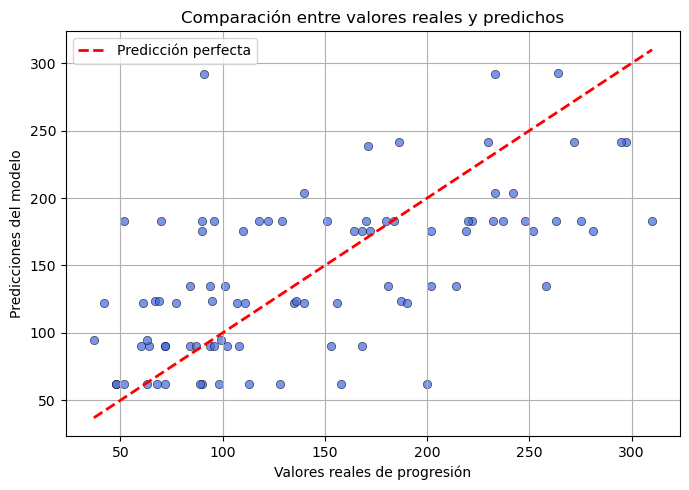

In [8]:
# Gráfica de dispersión: y real vs y predicho
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', edgecolor='black', alpha=0.7)

# Línea de referencia perfecta
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Predicción perfecta')

plt.xlabel('Valores reales de progresión')
plt.ylabel('Predicciones del modelo')
plt.title('Comparación entre valores reales y predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


El **coeficiente de determinación $R^2$** fue de **0.3264**, lo que significa que el modelo explica alrededor del **32.6% de la variabilidad total** en la progresión de la enfermedad. Si bien este valor es superior a 0 (lo que indica que el modelo es mejor que simplemente predecir la media), aún está lejos de ser un ajuste óptimo.

Esto sugiere que, aunque el árbol de decisión está capturando cierta estructura en los datos, todavía hay mucho margen de mejora. Es posible que el modelo esté **subajustando** los datos (es decir, que sea demasiado simple), o que necesitemos ajustar mejor sus hiperparámetros, profundizar el árbol o explorar modelos más complejos como Random Forest o Gradient Boosting.

### Características importantes

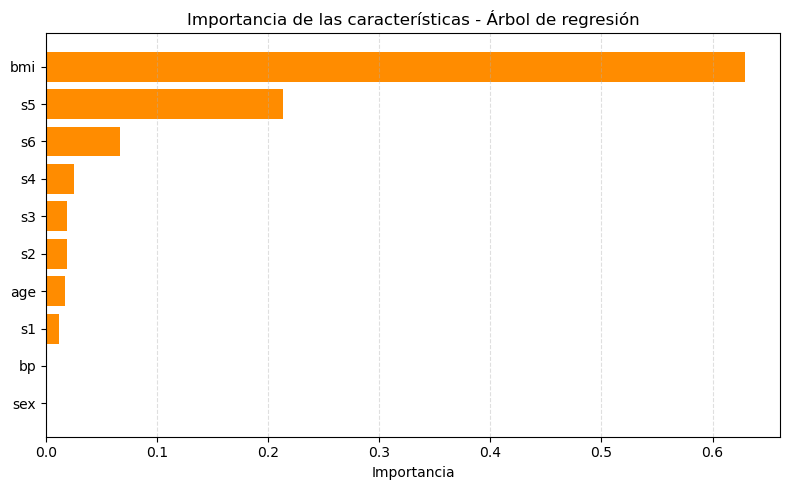

In [9]:
importances = tree_reg.feature_importances_
feature_names = tree_reg.feature_names_in_

# Crear DataFrame para ordenar las importancias
df_importances = pd.DataFrame({
    'variable': feature_names,
    'importances': importances
}).sort_values(by='importances', ascending=True)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(df_importances['variable'], df_importances['importances'], color='darkorange')
plt.xlabel("Importancia")
plt.title("Importancia de las características - Árbol de regresión")
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()


### Visualización del árbol

In [10]:
# Exportar árbol a formato dot
with open("diabetes_rtree.dot", 'w') as dotfile:
    export_graphviz(tree_reg, out_file=dotfile, feature_names=X_train.columns)
    dotfile.close()

In [11]:
# Abrimos el archivo generado
file = open("diabetes_rtree.dot", "r")
text = file.read()

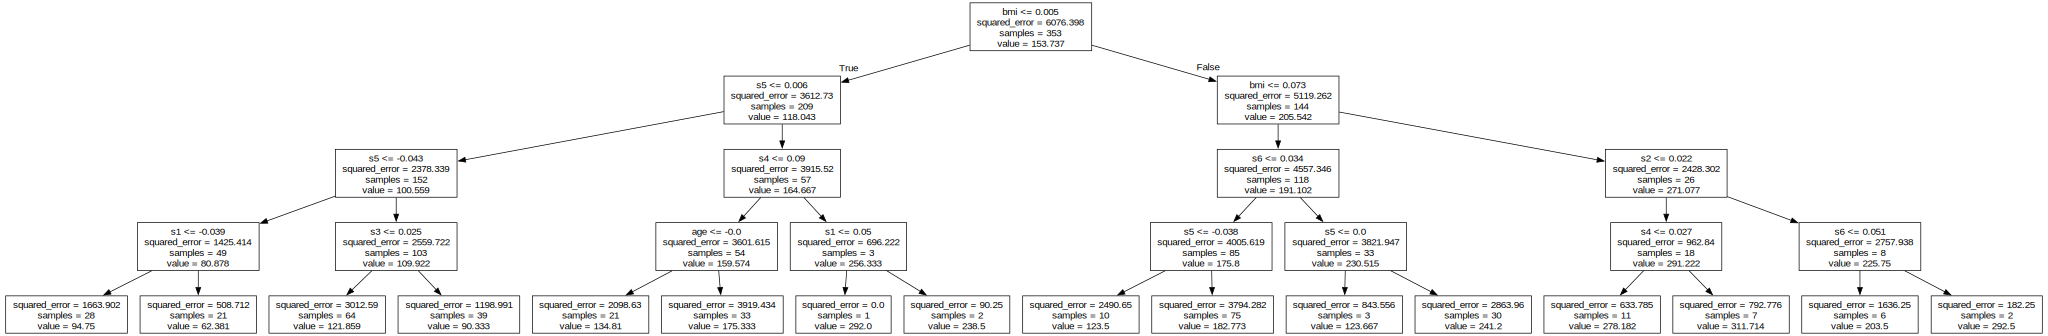

In [12]:
# Visualizacion con graphviz
Source(text)

#### ¿Cómo se agrupan las predicciones en las hojas?

En los árboles de regresión, el modelo divide el espacio de las variables de entrada en regiones (ramas) que terminan en nodos hoja. Cada una de estas hojas **representa un subconjunto del conjunto de entrenamiento** que cumple con ciertas condiciones (por ejemplo, `bmi <= 0.05` y `s5 > 0.2`). El valor de predicción asignado a cada hoja es simplemente el **promedio de los valores reales** (`progresion`) de todas las observaciones que llegan hasta esa hoja durante el entrenamiento.

Esto hace que el árbol de regresión **genere predicciones constantes por región**. Es decir, cualquier nuevo paciente que cumpla con las mismas condiciones de una hoja recibirá la misma predicción, sin importar pequeñas variaciones dentro de esa región. Esta estructura por bloques es una de las razones por las que los árboles pueden capturar relaciones no lineales, pero también puede hacer que las predicciones sean algo "escalonadas" o abruptas. Por ejemplo, revisa el diagrama de dispersión creado anteriormente.

### Poda del árbol

In [13]:
# Probamos distintas profundidades con del hiperparámetro max_depth

results = []

for d in range(1, 21):
    tree_reg = DecisionTreeRegressor(max_depth=d, random_state=42)
    tree_reg.fit(X_train, y_train)
    y_pred = tree_reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append({'max_depth': d, 'r2': r2})

# Convertimos resultados a DataFrame que podamos visualizar
df_r2 = pd.DataFrame(results)
display(df_r2)

,max_depth,r2
0,1,0.130529
1,2,0.294943
2,3,0.329445
3,4,0.326375
4,5,0.334482
5,6,0.307180
6,7,0.191084
7,8,0.278494
8,9,0.225485
9,10,0.171790


Este experimento de ajuste del hiperparámetro `max_depth` muestra claramente cómo la **profundidad del árbol afecta su capacidad de generalización**. Observamos que al aumentar la profundidad desde 1 hasta 5, el desempeño medido por $R^2$ mejora gradualmente, alcanzando un máximo alrededor de **0.334** en `max_depth = 5`. Esto indica que el modelo logra capturar mejor la estructura de los datos conforme se vuelve más flexible.

Sin embargo, a partir de ese punto, el rendimiento comienza a **degradarse** de manera evidente. En lugar de seguir mejorando, el modelo empieza a sobreajustar los datos de entrenamiento, perdiendo capacidad de generalizar sobre el conjunto de prueba. Esto se refleja en la caída del $R^2$, llegando incluso a valores negativos en `max_depth = 18`, lo que indica que **el modelo predice peor que una simple media constante**.

#### Ajuste automático de hiperparámetros con `GridSearchCV`

En las secciones anteriores probamos manualmente distintos valores de `max_depth` para ver cómo afectaban el desempeño del árbol de regresión. Aunque esto es útil para explorar el comportamiento del modelo, cuando queremos afinar múltiples hiperparámetros de forma sistemática y rigurosa, lo ideal es utilizar herramientas de búsqueda automática.

`GridSearchCV` es una utilidad de `scikit-learn` que nos permite realizar una **búsqueda en grid** sobre una combinación de hiperparámetros. Lo hace evaluando todas las combinaciones posibles utilizando **validación cruzada**, y selecciona aquella que obtiene el mejor desempeño promedio. Esta técnica nos permite encontrar la configuración óptima sin necesidad de separar un conjunto de validación manualmente.

In [14]:
# 1. Definimos un modelo base
model_base = DecisionTreeRegressor(random_state=42) # No especificamos parámetros

# 2. Definimos el grid de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# 3. Configurar GridSearch junto con los parámetros de la validación cruzada
grid = GridSearchCV(estimator=model_base, # modelo base
                    param_grid=param_grid, # grid de hiperparámetros
                    cv=5, # numero k fold 
                    scoring='r2', # métrica de referencia
                    n_jobs=1,  # usa un solo núcleo al procesar
                    return_train_score=True)

# 4. Entrenar el GridSearch con datos de entrenamiento (la evaluación vendrá posteriormente)
grid.fit(X_train, y_train)

# 5. Observamos los mejores parámetros que encontró
print('Mejores parámetros: ')
for key, value in grid.best_params_.items(): # best_params es un diccionario
    print(f'Mejor valor de {key}: {value}')
print(f"Mejor score promedio (R2 CV): {grid.best_score_:.4f}")

Mejores parámetros: 
Mejor valor de max_depth: 3
Mejor valor de min_samples_leaf: 5
Mejor valor de min_samples_split: 2
Mejor score promedio (R2 CV): 0.2867


## Random Forest para regresión

Como vimos anteriormente, un solo árbol de decisión puede ser muy sensible a los datos: si es muy profundo, puede sobreajustar; si es muy superficial, puede subajustar. Utilizamos Random Forest para intentar resolver esto.

In [15]:
# 1. Instanciamos el modelo
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    oob_score=True,
    random_state=42,
    n_jobs=1
)

# 2. Entrenamos
rf.fit(X_train, y_train)

# 3. Predicciones sobre el conjunto de prueba
y_pred_rf = rf.predict(X_test)

# 4. Evaluación
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}")
print(f"Random Forest - R2: {r2_rf:.4f}")
print(f"Random Forest - OOB Score (estimación): {rf.oob_score_:.4f}")


Random Forest - MSE: 2952.01
Random Forest - R2: 0.4428
Random Forest - OOB Score (estimación): 0.4461


El modelo de Random Forest obtuvo un **MSE de 2952.01** y un **coeficiente $R^2$ de 0.4428** sobre el conjunto de prueba, lo que representa una mejora respecto al árbol de decisión individual que tenía un $R^2$ de aproximadamente 0.33. Esto confirma que, al combinar múltiples árboles, el modelo logra una mejor capacidad de generalización y reduce la varianza.

Además, el **OOB Score** fue de **0.4461**, lo cual está muy cercano al valor de $R^2$ obtenido en prueba. Esto valida el uso del método *out-of-bag* como una alternativa eficiente para estimar el desempeño del modelo sin requerir un conjunto de validación adicional.

## Introducción al Gradient Boosting para regresión

El algoritmo de **Gradient Boosting** es una técnica de ensamblado avanzada que construye modelos fuertes a partir de modelos débiles, generalmente árboles poco profundos. A diferencia de Random Forest, que entrena muchos árboles de forma independiente (en paralelo), Gradient Boosting lo hace **de manera secuencial**, donde cada nuevo árbol trata de corregir los errores cometidos por los árboles anteriores.

El modelo resultante se construye como una suma aditiva de predictores:

\begin{equation}
\hat{y}(x) = \sum_{m=1}^{M} \gamma_m \cdot h_m(x)
\end{equation}

donde:
- $h_m(x)$ es el árbol $m$-ésimo entrenado sobre los errores residuales de los árboles anteriores,
- $\gamma_m$ es un peso o tasa de aprendizaje que controla cuánto contribuye cada árbol,
- y $M$ es el número total de árboles.

En cada iteración, el algoritmo entrena un nuevo árbol que se ajusta al **gradiente negativo del error**, es decir, la dirección en la que más se reduce la función de pérdida. En regresión, esta función de pérdida suele ser el **error cuadrático**:

\begin{equation}
L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2
\end{equation}

Por eso se le llama "boosting por gradiente": cada nuevo árbol avanza en la dirección que más reduce el error.

Gradient Boosting es especialmente útil cuando buscamos un modelo preciso y controlado, y su desempeño puede ser superior al de Random Forest en muchos contextos. Sin embargo, es más sensible al sobreajuste, por lo que el ajuste de hiperparámetros como la **tasa de aprendizaje (`learning_rate`)** o el **número de árboles (`n_estimators`)** es crucial para su buen funcionamiento.

In [16]:
# 1. Instanciamos el módelo
gbr = GradientBoostingRegressor(
    n_estimators=100,         # Número de árboles
    learning_rate=0.1,        # Tasa de aprendizaje (gamma)
    max_depth=3,              # Profundidad de cada árbol base
    random_state=42
)

# 2. Entrenamiento sobre conjunto de entrenamiento
gbr.fit(X_train, y_train)

# 3. Predicciones sobre conjunto de prueba
y_pred_gbr = gbr.predict(X_test)

# 4. Evaluación
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# Mostrar resultados
print(f"Gradient Boosting - MSE: {mse_gbr:.2f}")
print(f"Gradient Boosting - R²: {r2_gbr:.4f}")

Gradient Boosting - MSE: 2898.44
Gradient Boosting - R²: 0.4529


El modelo de Gradient Boosting obtuvo un **MSE de 2898.44** y un **coeficiente $R^2$ de 0.4529**, superando tanto al árbol de decisión individual como al modelo de Random Forest en este problema de regresión. Aunque la mejora respecto a Random Forest puede parecer pequeña, esta diferencia refleja una **mayor capacidad del modelo para adaptarse a patrones complejos** sin caer (aún) en sobreajuste.

Recordemos que, a diferencia de Random Forest, que entrena muchos árboles de forma paralela e independiente, Gradient Boosting **entrena árboles secuencialmente**, y cada uno intenta corregir los errores residuales del anterior. Esto lo hace más sensible y controlable, pero también más propenso a sobreajustar si no se ajustan bien parámetros como la tasa de aprendizaje (`learning_rate`) o la cantidad de árboles (`n_estimators`).

### Comparación de importancia de las características

In [17]:
# Volvemos a entrenar el primer modelo del árbol solo de regresion
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

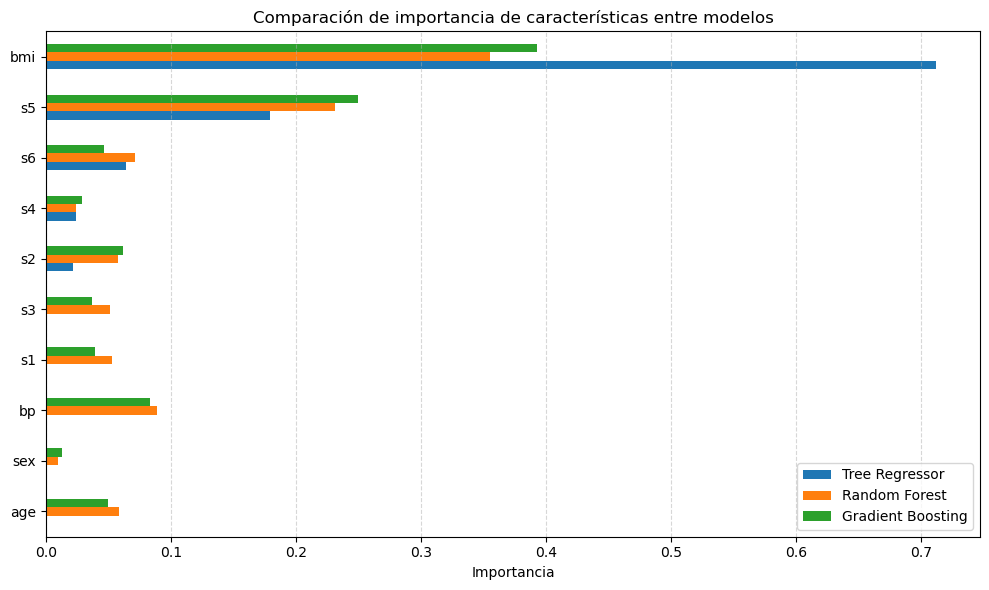

In [18]:
# Plot de comparación

# Importancias de cada modelo
imp_tree = pd.Series(tree_reg.feature_importances_, index=X.columns, name='Tree Regressor')
imp_rf = pd.Series(rf.feature_importances_, index=X.columns, name='Random Forest')
imp_gbr = pd.Series(gbr.feature_importances_, index=X.columns, name='Gradient Boosting')

# Combinar en un solo DataFrame
df_importances = pd.concat([imp_tree, imp_rf, imp_gbr], axis=1)

# Plot
df_importances.sort_values(by='Tree Regressor', ascending=True).plot.barh(figsize=(10,6))
plt.title('Comparación de importancia de características entre modelos')
plt.xlabel('Importancia')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

La comparación de importancia de características entre el árbol de decisión, Random Forest y Gradient Boosting revela patrones interesantes sobre cómo cada modelo interpreta las variables del dataset. En general, observamos que ciertas variables como **`bmi`** (índice de masa corporal) y **`s5`** (relacionada con triglicéridos) tienden a tener una alta relevancia en los tres modelos, lo cual indica una **consistencia estructural en su influencia sobre la progresión de la enfermedad**.

Sin embargo, también hay **variaciones sutiles** entre modelos. Por ejemplo, el árbol individual puede concentrar excesivamente la importancia en unas pocas variables (lo que es típico cuando hay sobreajuste), mientras que Random Forest y Gradient Boosting tienden a **distribuir la importancia de forma más equilibrada**, al combinar múltiples árboles con diferentes vistas del conjunto de datos.

Gradient Boosting, en particular, puede asignar importancia a variables que en otros modelos parecían menos relevantes, ya que cada árbol se entrena para corregir los errores del anterior, lo que le permite capturar efectos secundarios o sutiles que otros modelos podrían ignorar.

## Resumen y conclusiones

En este notebook exploramos distintos modelos de regresión basados en árboles aplicados al dataset *Diabetes*, comenzando con un árbol de decisión individual, seguido de dos métodos de ensamblado: **Random Forest** y **Gradient Boosting**. A lo largo del análisis:

- Observamos cómo los árboles de decisión segmentan el espacio de predicción en regiones constantes, lo que los hace interpretables pero también propensos al sobreajuste si no se regulan.
- Evaluamos el impacto del hiperparámetro `max_depth` sobre el rendimiento, y aprendimos a usar `GridSearchCV` para encontrar la configuración óptima mediante validación cruzada.
- Comparando modelos, vimos que **Random Forest** mejoró la capacidad de generalización al reducir la varianza mediante votación entre árboles, mientras que **Gradient Boosting** refinó aún más la predicción al corregir errores secuencialmente.

Este ejercicio nos permitió no solo comparar algoritmos de regresión, sino también entender cómo tomar decisiones informadas sobre la elección y ajuste de modelos, interpretabilidad y desempeño en problemas del mundo real.
